# PLEASE ENTER "OPENAI_API_KEY" in LINE 19
Please contact sv2744@columbia.edu for my OPENAI_API_KEY

In [ ]:
import os
import re
import json
import openai
import pdfplumber
from crewai import Agent, Task, Crew, Process
from langchain_openai import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage
import numpy as np
import pandas as pd
import ast

from flask import Flask, request, jsonify
from langchain.prompts import PromptTemplate
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory

# Set up environment for OpenAI API key
os.environ["OPENAI_API_KEY"] = "PLEASE ENTER OPENAI_API_KEY" ## put OPENAI_API_KEY here,
# Please contact sv2744@columbia.edu for my OPENAI_API_KEY
os.environ["OPENAI_MODEL_NAME"] = 'gpt-4-turbo'
chat_model = ChatOpenAI(model="gpt-4-turbo", api_key=os.environ["OPENAI_API_KEY"])

### 1. Survey data for training
these are from several risk assessment questionaires from the internet

In [14]:
survey = [
    ("In general, how would your best friend describe you as a risk taker?", [
        ("a) A real gambler", 100),
        ("b) Willing to take risks after completing adequate research", 75),
        ("c) Cautious", 50),
        ("d) A real risk avoider", 25)
    ]),
    ("How would you respond to the following statement? 'It's hard for me to pass up a bargain.'", [
        ("a) Very true", 33),
        ("b) Sometimes true", 66),
        ("c) Not at all true", 99)
    ]),
    ("If you unexpectedly received $20,000 to invest, what would you do?", [
        ("a) Deposit it in a bank account, money market account, or an insured CD", 33),
        ("b) Invest it in safe, high-quality bonds or bond mutual funds", 66),
        ("c) Invest it in stocks or stock mutual funds", 99)
    ]),
    ("In terms of experience, how comfortable are you investing in stocks or stock mutual funds?", [
        ("a) Not at all comfortable", 1),
        ("b) Somewhat comfortable", 2),
        ("c) Very comfortable", 3)
    ]),
    ("Which situation would make you the happiest?", [
        ("a) You win $50,000 in a publisher's contest", 2),
        ("b) You inherit $50,000 from a rich relative", 1),
        ("c) You earn $50,000 by risking $1,000 in the options market", 3),
        ("d) Any of the above—after all, you're happy with the $50,000", 1)
    ]),
    ("When you think of the word 'risk,' which of the following words comes to mind first?", [
        ("a) Loss", 1),
        ("b) Uncertainty", 2),
        ("c) Opportunity", 3),
        ("d) Thrill", 4)
    ]),
    ("You inherit a mortgage-free house worth $80,000. The house is in a nice neighborhood and you believe that it should increase in value faster than inflation. Unfortunately, the house needs repairs. If rented today, the house would bring in $600 monthly, but if updates and repairs were made, the house would rent for $800 per month. To finance the repairs, you'll need to take out a mortgage on the property. You would:", [
        ("a) Sell the house", 1),
        ("b) Rent the house as-is", 2),
        ("c) Remodel and update the house, and then rent it", 3)
    ]),
    ("In your opinion, is it more important to be protected from rising consumer prices (inflation) or to maintain the safety of your money from loss or theft?", [
        ("a) Much more important to secure the safety of my money", 1),
        ("b) Much more important to be protected from rising prices (inflation)", 3)
    ]),
    ("You've just taken a job at a small fast-growing company. After your first year, you are offered the following bonus choices. Which one would you choose?", [
        ("a) A five-year employment contract", 1),
        ("b) A $25,000 bonus", 2),
        ("c) Stock in the company currently worth $25,000 with the hope of selling out later at a large profit", 3)
    ]),
    ("Some experts are predicting prices of assets such as gold, jewels, collectibles, and real estate (hard assets) to increase in value; bond prices may fall. However, experts agree that government bonds are relatively safe. Most of your investment assets are now in high-interest government bonds. What would you do?", [
        ("a) Hold the bonds", 1),
        ("b) Sell the bonds, put half the proceeds into money market accounts, and the other half into hard assets", 2),
        ("c) Sell the bonds and put the total proceeds into hard assets", 3),
        ("d) Sell the bonds, put all the money into hard assets, and borrow additional money to buy more", 4)
    ]),
    ("Assume you are going to buy a home in the next few weeks. Your strategy would probably be:", [
        ("a) To buy an affordable house where you can make monthly payments comfortably", 1),
        ("b) To stretch a bit financially to buy the house you really want", 2),
        ("c) To buy the most expensive house you can qualify for", 3),
        ("d) To borrow money from friends and relatives so you can qualify for a bigger mortgage", 4)
    ]),
    ("Given the best and worst-case returns of the four investment choices below, which would you prefer?", [
        ("a) $200 gain best case; $0 gain/loss worst case", 1),
        ("b) $800 gain best case; $200 loss worst case", 2),
        ("c) $2,600 gain best case; $800 loss worst case", 3),
        ("d) $4,800 gain best case; $2,400 loss worst case", 4)
    ]),
    ("Assume that you are applying for a mortgage. Interest rates have been coming down over the past few months. There's the possibility that this trend will continue, but some economists predict rates to increase. You have the option of locking in your mortgage interest rate or letting it float. What would you do?", [
        ("a) Definitely lock in the interest rate", 1),
        ("b) Probably lock in the interest rate", 2),
        ("c) Probably let the interest rate float", 2),
        ("d) Definitely let the interest rate float", 3)
    ]),
    ("In addition to whatever you own, you have been given $1,000. You are now asked to choose between:", [
        ("a) A sure gain of $500", 1),
        ("b) A 50% chance to gain $1,000 and a 50% chance to gain nothing", 3)
    ]),
    ("In addition to whatever you own, you have been given $2,000. You are now asked to choose between:", [
        ("a) A sure loss of $500", 1),
        ("b) A 50% chance to lose $1,000 and a 50% chance to lose nothing", 3)
    ]),
    ("Suppose a relative left you an inheritance of $100,000, stipulating in the will that you invest ALL the money in ONE of the following choices. Which one would you select?", [
        ("a) A savings account or money market mutual fund", 1),
        ("b) A mutual fund that owns stocks and bonds", 2),
        ("c) A portfolio of 15 common stocks", 3),
        ("d) Commodities like gold, silver, and oil", 4)
    ]),
    ("If you had to invest $20,000, which of the following investment choices would you find most appealing?", [
        ("a) 60% in low-risk investments, 30% in medium-risk investments, 10% in high-risk investments", 1),
        ("b) 30% in low-risk investments, 40% in medium-risk investments, 30% in high-risk investments", 2),
        ("c) 10% in low-risk investments, 40% in medium-risk investments, 50% in high-risk investments", 3)
    ]),
    ("Your trusted friend and neighbor, an experienced geologist, is putting together a group of investors to fund an exploratory gold mining venture. The venture could pay back 50 to 100 times the investment if successful, but if the mine fails, the entire investment is worthless. Your friend estimates the chance of success is only 20%. How much would you invest?", [
        ("a) Nothing", 1),
        ("b) One month’s salary", 2),
        ("c) Three months’ salary", 3),
        ("d) Six months’ salary", 4)
    ]),
    ("My current age is:", [
        ("a) Over 70", 1),
        ("b) 60 to 70", 3),
        ("c) 46 to 59", 7),
        ("d) 45 or younger", 10)
    ]),

    ("I plan to withdraw money from my retirement plan account in:", [
        ("a) Less than 5 years", 1),
        ("b) 5 to 9 years", 3),
        ("c) 10 to 15 years", 6),
        ("d) More than 15 years", 8)
    ]),
    ("I should have enough savings and stable/guaranteed income to maintain my planned standard of living in retirement:", [
        ("a) Not confident", 1),
        ("b) Somewhat confident", 2),
        ("c) Confident", 4),
        ("d) Very confident", 6)
    ]),
    ("The following statement best describes my willingness to take risk:", [
        ("a) I’m more concerned with avoiding losses in my account value than with experiencing growth.", 1),
        ("b) I desire growth of my account value, but I’m more concerned with avoiding losses.", 3),
        ("c) I’m concerned with avoiding losses, but this is outweighed by my desire to achieve growth.", 5),
        ("d) To maximize the chance of experiencing high growth, I’m willing to accept losses.", 7)
    ]),
    ("If I invested $100,000 and my portfolio value decreased to $70,000 in just a few months, I would:", [
        ("a) Be very concerned and sell my investments", 1),
        ("b) Be somewhat concerned and consider allocating to lower-risk investments", 2),
        ("c) Be unconcerned about the temporary fluctuations in my returns", 4),
        ("d) Invest more in my current portfolio", 5)
    ]),
    ("My assets (excluding home and car) are invested in:", [
        ("a) I don’t know how my assets are invested.", 1),
        ("b) My pension, certificates of deposit (CDs), annuities, IRA, and savings accounts", 2),
        ("c) A mix of stocks and bonds, including mutual funds", 3),
        ("d) Stocks or stock mutual funds", 4)
    ]),
    ("I plan to begin taking money from my investments in:", [
        ("A) Less than 1 year", 0),
        ("B) 1 to 2 years", 1),
        ("C) 3 to 5 years", 4),
        ("D) 6 to 10 years", 7),
        ("E) 11 to 15 years", 12),
        ("F) More than 15 years", 17)
    ]),
    ("As I withdraw money from these investments, I plan to spend it over a period of:", [
        ("A) 2 years or less", 0),
        ("B) 3 to 5 years", 1),
        ("C) 6 to 10 years", 3),
        ("D) 11 to 15 years", 5),
        ("E) More than 15 years", 8)
    ]),
    ("When making a long-term investment, I plan to keep my money invested for:", [
        ("A) 1 to 2 years", 0),
        ("B) 3 to 4 years", 1),
        ("C) 5 to 6 years", 3),
        ("D) 7 to 8 years", 5),
        ("E) More than 8 years", 7)
    ]),
    ("If I owned a stock investment that lost about 31% in three months, I would:", [
        ("A) Sell all of the remaining investment", 1),
        ("B) Sell some of the remaining investment", 3),
        ("C) Hold on to the investment and sell nothing", 5),
        ("D) Buy more of that investment", 6)
    ]),
    ("Generally, I prefer an investment with little or no ups or downs in value, and I am willing to accept the lower returns these investments may generate.", [
        ("A) I strongly disagree", 6),
        ("B) I disagree", 5),
        ("C) I somewhat agree", 3),
        ("D) I agree", 1),
        ("E) I strongly agree", 0)
    ]),
    ("When the market goes down, I tend to sell some of my riskier investments and put money in safer investments.", [
        ("A) I strongly disagree", 5),
        ("B) I disagree", 4),
        ("C) I somewhat agree", 3),
        ("D) I agree", 2),
        ("E) I strongly agree", 1)
    ]),
    ("Based only on a brief conversation with a friend, coworker, or relative, I would invest in a mutual fund.", [
        ("A) I strongly disagree", 5),
        ("B) I disagree", 4),
        ("C) I somewhat agree", 3),
        ("D) I agree", 2),
        ("E) I strongly agree", 1)
    ]),
    ("If I owned a bond investment that lost almost 4% in two months, I would:", [
        ("A) Sell all of the remaining investment", 1),
        ("B) Sell some of the remaining investment", 3),
        ("C) Hold on to the investment and sell nothing", 5),
        ("D) Buy more of that investment", 6)
    ]),
    ("Given the potential gain or loss in any one year, I would invest my money in:", [
        ("A) Investment A (gain $593; loss $164)", 1),
        ("B) Investment B (gain $1,921; loss $1,020)", 3),
        ("C) Investment C (gain $4,229; loss $3,639)", 5)
    ]),
    ("My current and future income sources (such as salary, Social Security, pension) are:", [
        ("A) Very unstable", 1),
        ("B) Unstable", 2),
        ("C) Somewhat stable", 3),
        ("D) Stable", 4),
        ("E) Very stable", 5)
    ]),
    ("When it comes to investing in stock or bond mutual funds (or individual stocks or bonds), I would describe myself as:", [
        ("A) Very inexperienced", 1),
        ("B) Somewhat inexperienced", 2),
        ("C) Somewhat experienced", 3),
        ("D) Experienced", 4),
        ("E) Very experienced", 5)
    ]),
    
    ("What is your current age?", [
        ("a) Over 65", 1),
        ("b) Age 55-65", 2),
        ("c) Age 45-54", 3),
        ("d) Age 35-44", 4),
        ("e) Under 35", 5)
    ]),
    ("How soon do you expect to need the money you are investing in your employer-sponsored retirement savings plan account?", [
        ("a) Less than 1 year", 1),
        ("b) 1-5 years", 2),
        ("c) 6-10 years", 3),
        ("d) 11-20 years", 4),
        ("e) More than 20 years", 5)
    ]),
    ("Looking ahead to the next five years, which of the following statements best describes your outlook?", [
        ("a) I may be laid off or plan to retire", 1),
        ("b) My annual income will likely be reduced", 2),
        ("c) My income tends to greatly fluctuate", 3),
        ("d) My income will not likely change", 4),
        ("e) My income will most likely increase steadily", 5)
    ]),
    ("Do you have enough non-retirement assets to cover expenses for:", [
        ("a) One month or less", 1),
        ("b) 2-3 months", 2),
        ("c) 4-6 months", 3),
        ("d) 6 months to 1 year", 4),
        ("e) More than 1 year", 5)
    ]),
    ("When do you plan to retire?", [
        ("a) 1-5 years", 1),
        ("b) 6-10 years", 2),
        ("c) 11-15 years", 3),
        ("d) 16-20 years", 4),
        ("e) 21+ years", 5)
    ]),
    ("Please rate your tolerance for investment risk:", [
        ("a) Very low", 1),
        ("b) Moderately low", 2),
        ("c) Average", 3),
        ("d) Moderately high", 4),
        ("e) Very high", 5)
    ]),
    ("The goal for your 401(k) account is:", [
        ("a) To keep the balance in cash; not concerned with inflation", 1),
        ("b) To keep my balance safe from losses but in line with inflation", 2),
        ("c) To receive a moderate return, higher than inflation", 3),
        ("d) To continuously grow assets above average", 4),
        ("e) To significantly increase wealth with high returns", 5)
    ]),
    ("If you were to invest $100,000 over five years, which best/worst case scenarios would you accept?", [
        ("a) $110,000 best / $100,000 worst", 1),
        ("b) $120,000 best / $98,000 worst", 2),
        ("c) $150,000 best / $90,000 worst", 3),
        ("d) $180,000 best / $70,000 worst", 4),
        ("e) $200,000 best / $50,000 worst", 5)
    ]),
    ("When you learn the value of your investments dropped 30%, you would:", [
        ("a) Sell immediately", 1),
        ("b) Sell if it drops further", 2),
        ("c) Wait until value returns, then sell", 3),
        ("d) Continue to hold long-term", 4),
        ("e) Buy more", 5)
    ]),
    ("For these funds, which of the following closely aligns with your current financial goal?", [
        ("A) Sustaining current income and account preservation", 0),
        ("B) Sustaining current income with possible growth opportunity", 10),
        ("C) Growing account value, not tied to current income needs", 20),
        ("D) Aggressive growth, maximizing accumulation", 30)
    ]),
    ("How long do you plan to keep these funds invested in order to achieve your financial goal?", [
        ("A) Less than 1 year", 0),
        ("B) 1 to 2 years", 3),
        ("C) 3 to 5 years", 8),
        ("D) 6 to 10 years", 15),
        ("E) 11 to 20 years", 23),
        ("F) Greater than 20 years", 30)
    ]),
    ("How much potential risk and reward are you willing to invest in with these funds?", [
        ("A) Lowest risk and reward", 0),
        ("B) Low risk and reward", 3),
        ("C) Moderate risk and reward", 5),
        ("D) High risk and reward", 8),
        ("E) Highest risk and reward", 10)
    ]),
    ("How would you react to a significant fall in the value of the stock market?", [
        ("A) Sell All, Avoid Further Risk", 0),
        ("B) Sell Some, Reduce Exposure to Risk", 3),
        ("C) Sell Nothing, Remain Invested", 7),
        ("D) Buy More, Opportunity is Present", 10)
    ]),
    ("How soon would you need these funds to recover after experiencing a sudden meaningful loss in value?", [
        ("A) 0 to 6 months", 0),
        ("B) 6 months to 1 year", 3),
        ("C) 1 to 3 years", 7),
        ("D) 3 years or more", 10)
    ]),
    ("I am comfortable investing during times of uncertainty.", [
        ("A) Strongly disagree", 0),
        ("B) Disagree", 3),
        ("C) Agree", 7),
        ("D) Strongly agree", 10)
    ]),
    ("When do you want to start spending the money you will save in this account?", [
        ("A) Immediately or within the next three years", 0),
        ("B) Within three to four years", 6),
        ("C) Within five to six years", 10),
        ("D) Within seven to 10 years", 15),
        ("E) Not within the next 10 years", 20)
    ]),
    ("Once you start spending your money, how long do you expect to continue to withdraw funds?", [
        ("A) I plan to withdraw all of my money at once", 0),
        ("B) I will make withdrawals over two to five years", 2),
        ("C) I will make withdrawals over six to 10 years", 5),
        ("D) I will make withdrawals over 10 years or more", 7),
        ("E) I don’t intend to withdraw the money", 10)
    ]),
    ("Once you start to spend the money in your investment portfolio, how much do you plan to withdraw?", [
        ("A) I do not intend to take withdrawals", 10),
        ("B) I plan to withdraw between 0% and 4%", 7),
        ("C) I plan to withdraw between 4% and 8%", 5),
        ("D) I plan to withdraw more than half within three to 10 years", 2),
        ("E) I plan to withdraw all of my investments at once", 0)
    ]),
    ("Which investment scenario would you choose for potential gains and losses?", [
        ("A) Scenario A (Max gain: 17%; Max loss: -12%)", 0),
        ("B) Scenario B (Max gain: 23%; Max loss: -15%)", 4),
        ("C) Scenario C (Max gain: 28%; Max loss: -19%)", 7),
        ("D) Scenario D (Max gain: 34%; Max loss: -22%)", 10),
        ("E) Scenario E (Max gain: 39%; Max loss: -25%)", 14)
    ]),
    ("Imagine you have invested R100,000. Which portfolio would you choose?", [
        ("A) Scenario A (Best-case: R17,000; Likely: R4,500; Worst-case: -R12,000)", 0),
        ("B) Scenario B (Best-case: R23,000; Likely: R6,000; Worst-case: -R15,000)", 4),
        ("C) Scenario C (Best-case: R28,000; Likely: R7,000; Worst-case: -R19,000)", 7),
        ("D) Scenario D (Best-case: R34,000; Likely: R8,000; Worst-case: -R22,000)", 10),
        ("E) Scenario E (Best-case: R39,000; Likely: R9,000; Worst-case: -R25,000)", 14)
    ]),
    ("Which statement best describes your attitude to risk?", [
        ("A) Most concerned with risk, willing to accept lower returns", 0),
        ("B) Willing to accept some risk for modest returns", 4),
        ("C) Willing to accept moderate risk, balancing returns and risk", 7),
        ("D) Want strong returns, willing to accept higher risk", 10),
        ("E) Mainly concerned with high returns, willing to accept significant risk", 14)
    ]),
    
    ("If your investment dropped from R100,000 to R80,000, how would you react?", [
        ("A) I would not change my investment plan", 15),
        ("B) Wait at least one year before changing", 10),
        ("C) Wait at least six months before changing", 5),
        ("D) Change to more stable options immediately", 0)
    ]),
    ("How much would you need to lose before switching to a more stable investment?", [
        ("A) R5,000 or less", 0),
        ("B) R10,000", 4),
        ("C) R15,000", 7),
        ("D) R20,000", 10),
        ("E) Unlikely to move money even if value falls", 14)
    ]),
    ("How does concern about losses affect your investment strategy?", [
        ("A) I would sell my investments immediately", 0),
        ("B) Concerned, but would sell after several months of losses", 5),
        ("C) Would wait a full year before making changes", 10),
        ("D) No changes; understand that investments fluctuate", 15)
    ]),
    ("What is your general view on investing?", [
        ("A) My investments don’t need to grow, I just want safety", 0),
        ("B) Accept lower growth for greater certainty", 4),
        ("C) More concerned about losses than gains", 7),
        ("D) Accept possible losses for long-term growth", 10),
        ("E) High growth requires taking risks", 14)
    ])
]

In [15]:
risk_levels = {
    "1-20": {
        "risk_level": "Low Risk",
        "type": "Fixed Income Investor",
        "score_range": "1–20 points",
        "characteristics": [
            "Focused on preserving capital with minimal risk exposure.",
            "Prefers steady, reliable income sources.",
            "Highly risk-averse and avoids market volatility."
        ],
        "indicators": [
            "Invests primarily in bonds, treasury securities, and money market funds.",
            "Little to no exposure to equities or high-risk assets.",
            "Minimal tolerance for fluctuations in portfolio value.",
            "Often prioritizes short-term liquidity and safety over long-term growth."
        ],
        "investor_profile": "Suitable for retirees or individuals with limited investment knowledge."
    },
    "21-40": {
        "risk_level": "Low-to-Moderate Risk",
        "type": "Conservative Growth Investor",
        "score_range": "21–40 points",
        "characteristics": [
            "Seeks steady income with some potential for capital growth.",
            "Focuses on maintaining portfolio stability while cautiously exploring higher-yield investments.",
            "Slightly risk-averse but open to minor market fluctuations."
        ],
        "indicators": [
            "Allocates the majority of investments to fixed-income securities, with a smaller portion in stock funds.",
            "Prefers blue-chip stocks or dividend-paying equities for growth potential.",
            "Willing to take limited risks to achieve modest returns.",
            "Typically has some experience with basic investment strategies."
        ],
        "investor_profile": "Ideal for those nearing retirement or with medium-term financial goals."
    },
    "41-60": {
        "risk_level": "Moderate Risk",
        "type": "Balanced Growth Investor",
        "score_range": "41–60 points",
        "characteristics": [
            "Strives for a balance between income and capital appreciation.",
            "Willing to accept moderate risk in exchange for growth opportunities.",
            "Comfortable with portfolio diversification across asset classes."
        ],
        "indicators": [
            "Invests equally in fixed-income and equity funds to maintain balance.",
            "Open to moderate market volatility for long-term gains.",
            "Seeks diversified investments across industries and regions.",
            "Demonstrates a growing understanding of financial markets and investment strategies."
        ],
        "investor_profile": "Suitable for individuals in mid-career stages or those with a medium to long-term investment horizon."
    },
    "61-80": {
        "risk_level": "Moderate-to-High Risk",
        "type": "Moderate Growth Investor",
        "score_range": "61–80 points",
        "characteristics": [
            "Growth-oriented with an emphasis on capital appreciation.",
            "Willing to tolerate higher levels of market volatility.",
            "Aims to achieve above-average returns while maintaining some stability through fixed-income assets."
        ],
        "indicators": [
            "Allocates a majority of investments to equities, with a smaller portion in fixed-income securities.",
            "Prefers growth stocks, mutual funds, or ETFs with moderate risk profiles.",
            "Comfortable with occasional significant market fluctuations.",
            "Has a solid understanding of investment strategies and market trends."
        ],
        "investor_profile": "Ideal for individuals with long-term goals, such as wealth accumulation for retirement."
    },
    "81-100": {
        "risk_level": "High Risk",
        "type": "High Growth Investor",
        "score_range": "81–100 points",
        "characteristics": [
            "Aggressively seeks maximum growth potential with a long-term focus.",
            "Highly tolerant of market volatility and short-term losses.",
            "Focuses on building substantial wealth through high-risk, high-reward investments."
        ],
        "indicators": [
            "Primarily invests in stocks, including small-cap and international equities.",
            "Interested in alternative investments such as venture capital, private equity, or cryptocurrencies.",
            "Rarely holds significant fixed-income securities or low-risk assets.",
            "Demonstrates extensive investment experience and comfort with complex financial instruments."
        ],
        "investor_profile": "Best suited for experienced investors or those with a high level of disposable income and long-term investment goals."
    }
}

Standardize the scores because the scoring scale varies across different questionaires.

In [16]:
def create_form_df(data):
    question_texts, answer_options, scores = [], [], []
    for question, answers in data:
        for answer_text, score in answers:
            question_texts.append(question)
            answer_options.append(answer_text)
            scores.append(score)
    return pd.DataFrame({"Question": question_texts, "AnswerOption": answer_options, "Score": scores})

# Create DataFrame for the survey
df = create_form_df(survey)

# Calculate maximum score for each question and adjust each answer's score to a 100-point scale
df['MaxScore'] = df.groupby('Question')['Score'].transform('max')
df['AdjustedScore'] = (df['Score'] / df['MaxScore']) * 100

# Drop unnecessary columns
df = df.drop(columns=['Score', 'MaxScore']).rename(columns={'AdjustedScore': 'Score'})

# Function to convert DataFrame back to original survey format
def df_to_survey_format(df):
    survey_list = []
    questions = df['Question'].unique()

    for question in questions:
        answers = df[df['Question'] == question][['AnswerOption', 'Score']]
        answer_list = [(row['AnswerOption'], round(row['Score'], 2)) for _, row in answers.iterrows()]
        survey_list.append((question, answer_list))

    return survey_list

# Convert the DataFrame back to the original survey format
survey = df_to_survey_format(df)
survey = [] # don't use survey if want to save API token

### 2. Question Generation

Topic to ask :
1. Investment Knowledge and Experience: familiar types of investments, past experience
2. Financial Situation: income, savings, and existing investment portfolio?
3. Investment Objectives:(retirement, buying a home, ST, LT)? Income Stability: cover living expenses? stable primary income source? emergency fund? reinvest returns?
4. Time Horizon: When access the invested funds? 
5. Risk Tolerance: comfortable investments fluctuate? reaction ? absorb How much loss
6. Investment Preferences: industries prefer oravoid? ethical or ESG considerations?

In [17]:
# Define system messages for guiding the conversation
system_message = SystemMessage(
    content=(
        "You are a friendly and engaging investment advisor on a team assessing clients' investment risk profiles. "
        "The team is divided into five sectors, each focusing on a topic relevant to risk assessment: "
        "1) Investment Knowledge and Experience, 2) Financial Situation, 3) Investment Objectives and Horizon, "
        "4) Risk Tolerance, and 5) Investment Preferences. "
        "Your role is to ask questions that feel naturally connected to each subtopic, encouraging open, comfortable,"
        "easy to understand for people without financial knowledge, related to daily life, yet concise discussions."
        "To be concise I mean don't add what clients have answered and don't explain why you have to ask a particular questions "
        "Approach each question with warmth, curiosity, and attentiveness to foster an engaging client conversation."
        "Each question should build on the client's responses to maintain a smooth, progressive conversation."
        "Your work is the basis for Senior Risk Assessment Officer to score client risk tolerance level."
        "A question should focus on a single idea and avoid lengthy, complex sentences."
        "Generate a follow-up question based on the previous response."
        "Avoid referencing or rephrasing the answer and directly ask the next question, maintaining context."
    )
)

def dynamic_questioning_gpt(client_responses, topic, chat_model, asked_questions):
    conversation_context = [system_message]
    
    # Associate documents and add specific comments based on the topic
    if topic == "Investment Knowledge and Experience":
        specific_comment = ""
        
    elif topic == "Financial Situation":
        specific_comment = ""
        
    elif topic == "Investment Objectives and Horizon":
        specific_comment = ""
        
    elif topic == "Risk Tolerance":
        specific_comment = """
        Focus on engaging the client in different daily life thought experiments.
        Blend the latest trends and news in the financial market into the questions as examples
        to make them more relevant to the client."""
        
    elif topic == "Investment Preferences":
        specific_comment = "Seek insights into the industries clients prefer or avoid, as well as the ESG aspects that are valuable to them—such as ethical practices, environmental impact, or social responsibility."
        
    else:
        specific_comment = "General financial topic, provide a balanced set of questions."

    # Add client responses to the conversation context
    for entry in client_responses:
        conversation_context.append(HumanMessage(content=f"{entry['question']}"))
        conversation_context.append(HumanMessage(content=f"{entry['answer']}"))
    
    # If no client responses yet, ask the initial question
    if not client_responses:
        next_question = f"To start with, how would you say your knowledge is when it comes to investment and financial markets?"
    else:
        # Generate the next question dynamically based on the conversation so far
        conversation_context.append(HumanMessage(
            content="If the previous client's answer is a question seeking clarification about the agent's question, then answer that question and provide additional explanation.\n"
                    f"Otherwise, ask a further open-ended question to better understand the client in the {topic} topic.\n"
                    f"{specific_comment}"
        ))
        response = chat_model.invoke(conversation_context)
        next_question = response.content 

    return next_question

# Function to ask the client if they want to start a new session
def ask_to_start_new_session():
    while True:
        new_session_input = input("Would you like to start a new session? (yes/no): ").strip().lower()
        if new_session_input in ['yes', 'no']:
            return new_session_input == 'yes'
        else:
            print("Please respond with 'yes' or 'no'.")

# Simulated chat interface for gathering financial risk profile and tolerance
def chat_interface(chat_model, client_responses=None):
    stages = {
        1: "Investment Knowledge and Experience",
        2: "Financial Situation", 
        3: "Investment Objectives and Horizon",
        4: "Risk Tolerance",
        5: "Investment Preferences"
    }

    if client_responses is None:
        client_responses = []  # Initialize responses if not provided
    
    asked_questions = []  # Track the questions asked
    
    stage = 1
    print("Welcome to the financial risk assessment chat.")
    
    while stage <= 5:  # Adjust for the new stage
        topic = stages[stage]
        
        for _ in range(7): # Ask 7 questions for each stage
            next_question = dynamic_questioning_gpt(client_responses, topic, chat_model, asked_questions)
            print()
            print(f"Agent: {next_question}")
            print()
            # Client response
            user_input = input("Your response: ")

            # Store both the question and the response
            client_responses.append({
                "question": next_question,
                "answer": user_input
            })

            # Track the question to avoid asking similar ones later
            asked_questions.append(next_question)

            if "exit" in user_input.lower():
                print("Thank you for participating in the financial risk assessment.")
                return client_responses

        # Move to the next section
        stage += 1
        if stage <= 5:  # Adjust for the new stage
            print(f"\nMoving to the next section: {stages[stage]}...\n")

    print("Thank you for completing the financial risk assessment.")

    # Ask the client if they want to start a new session
    if ask_to_start_new_session():
        print("\nStarting a new session...\n")
        chat_interface(chat_model)  # Start a new session by calling the function again
    else:
        print("Goodbye! Have a great day.")
        
    return client_responses

In [ ]:
# Collect responses and generate a summary with the Advisor
responses = chat_interface(chat_model)

In [ ]:
with open('Chat_log.json', 'w') as file: json.dump(responses, file, indent=4)

In [7]:
with open('Chat_log.json', 'r') as file: responses = json.load(file)

Split the chat log into five distinct topics, with each topic subsequently sent to a corresponding scoring agent.

In [8]:
def split_responses_into_lists(client_responses):
    # Initialize lists for each subtopic
    investment_knowledge_and_experience = []
    financial_situation = []
    investment_objectives_and_horizon = []
    risk_tolerance = []
    investment_preferences = []

    # Calculate the chunk size for each list based on total responses
    chunk_size = len(client_responses) // 5
    
    # Distribute the responses into each category by slicing
    investment_knowledge_and_experience = client_responses[:chunk_size]
    financial_situation = client_responses[chunk_size:chunk_size * 2]
    investment_objectives_and_horizon = client_responses[chunk_size * 2:chunk_size * 3]
    risk_tolerance = client_responses[chunk_size * 3:chunk_size * 4]
    investment_preferences = client_responses[chunk_size * 4:]
    
    return (investment_knowledge_and_experience, financial_situation, 
            investment_objectives_and_horizon, risk_tolerance, 
            investment_preferences)

# Unpack the function output into separate variables
investment_knowledge_and_experience, financial_situation, investment_objectives_and_horizon, \
risk_tolerance, investment_preferences = split_responses_into_lists(responses)

In [9]:
topic = ["Investment Knowledge and Experience","Financial Situation", 
         "Investment Objectives and Horizon","Risk Tolerance"]

# 3. Create Agent

In [10]:
# Define a base class for Topic Scorer Agent
class TopicScorerAgent(Agent):
    def __init__(self, topic):
        super().__init__(
            role=f"Risk Tolerance Scorer on {topic} topic",
            goal=(
                f"Your task is to evaluate the client's responses on the topic of {topic} and assign a risk tolerance score to each question. "
                f"The score should be on a 1 to 100 scale, with higher scores indicating higher risk tolerance."
            ),
            backstory=(
                f"You are an experienced assessor in the field of {topic} with a focus on understanding client risk tolerance through specific questions."
                "You are also experienced analyst with expertise in financial markets, personal finance, risk assessment, and communication. "
                "You are skilled at evaluating the context in communications."
            ),
            allow_delegation=False,
            verbose=True
)

# Define 4 agents for each topic
investment_knowledge_agent = TopicScorerAgent("Investment Knowledge and Experience")
financial_situation_agent = TopicScorerAgent("Financial Situation")
investment_objectives_agent = TopicScorerAgent("Investment Objectives and Horizon")
risk_tolerance_agent = TopicScorerAgent("Risk Tolerance")

# Define investment_preferences_agent
investment_preferences_agent = Agent(
    role= ("Investment Preferences Analyzer"),
    goal= (
        "Review the client conversations provided and identify any mentions of industries, sectors, or themes the client prefers or explicitly avoids."
        "Take note of any industries they frequently reference positively or negatively, or those with strong preferences."
        "Identify any indications of ethical values or ESG considerations that may influence the client’s investment preferences."
        " This could include preferences for sustainable, socially responsible, or environmentally-friendly investments,"
        " or any ethical constraints against specific industries (e.g., fossil fuels, tobacco, defense)."
        "Based on the identified preferences, list stocks within the S&P 500 that might conflict with these preferences."
        " For example, if the client has a strong ESG focus, highlight any high-carbon-emission companies or companies flagged for ethical controversies."
    ),
    backstory=(
        "An experienced analyst specialized in discerning client investment preferences through conversation insights. "
        "The agent understands the nuances of various industries, ESG criteria, and ethical concerns common among investors. "
        "They are also familiar with the S&P 500 and are capable of pinpointing stocks that may conflict with client interests. "
        "The agent has access to the latest industry, ethical, and ESG data to ensure recommendations align with client values."
    ),
    allow_delegation=False,
    verbose=True
)

# Define summary_agent
overall_summary_agent = Agent(
    role= ("Overall Risk Tolerance Summary Agent"),
    goal= (
        "Your task is to gather the individual scores and explanations from each topic scorer agent "
        "and summarize the client’s overall risk tolerance. Calculate the average score across all topics and "
        "provide a brief explanation that highlights key insights or patterns."
        "Include the Investment Preferences section at the end of the risk score report."
    ),
    backstory=(
        "You are an expert in summarizing risk tolerance assessments and identifying patterns from multiple topics. "
        "Your analysis will help create an overarching risk profile for the client based on their responses."
    ),
    allow_delegation=False,
    verbose=True
)

# 4. Create Task

In [18]:
# Define tasks for each topic scorer agent
investment_knowledge_task = Task(
    description=(
        "Assess the client’s responses in {investment_knowledge_and_experience} regarding their Investment Knowledge and Experience."
        "Using {survey} adn {risk_levels} as a guideline, assign a risk tolerance score"
        "Risk tolerance score should be between 1 and 100, where a higher score indicates higher risk tolerance. "
        "If a response is mostly irrelevant (80% or more unrelated to the question’s topic or intent), assign an 'n.a.' score."
        "Risk tolerance score will be use in investment recommendations."
        "Output a table with question, client answer, score, and brief explanation for each score."
        "Finally, calculate the overall score for the topic by averaging all individual scores."
    ),
    expected_output=(
        "Generate a line-by-line report for each question with the following format:"
        "Question: [Question text]"
        "Answer: [Client Answer]"
        "Score: [Score]"
        "Explanation: [Explanation of the score]"
        "At the end of the report, include a row with the Overall Score, calculated as the average of all scores."
    ),
    async_execution=False,
    agent=investment_knowledge_agent
)

financial_situation_task = Task(
    description=(
        "Assess the client’s responses in {financial_situation} regarding their financial situation."
        "Using {survey} as a guideline, assign a risk tolerance score"
        "Risk tolerance score should be between 1 and 100, where a higher score indicates higher risk tolerance. "
        "If a response is mostly irrelevant (80% or more unrelated to the question’s topic or intent), assign an 'n.a.' score."
        "Risk tolerance score will be use in investment recommendations."
        "Output a table with question, client answer, score, and brief explanation for each score."
        "Finally, calculate the overall score for the topic by averaging all individual scores."
    ),
    expected_output=(
        "Generate a line-by-line report for each question with the following format:"
        "Question: [Question text]"
        "Answer: [Client Answer]"
        "Score: [Score]"
        "Explanation: [Explanation of the score]"
        "At the end of the report, include a row with the Overall Score, calculated as the average of all scores."
    ),
    async_execution=False,
    agent=financial_situation_agent
)

investment_objectives_task = Task(
    description=(
        "Assess the client’s responses in {investment_objectives_and_horizon} regarding their Investment Objectives and Horizon."
        "Using {survey} as a guideline, assign a risk tolerance score"
        "Risk tolerance score should be between 1 and 100, where a higher score indicates higher risk tolerance. "
        "If a response is mostly irrelevant (80% or more unrelated to the question’s topic or intent), assign an 'n.a.' score."
        "Risk tolerance score will be use in investment recommendations."
        "Output a table with question, client answer, score, and brief explanation for each score."
        "Finally, calculate the overall score for the topic by averaging all individual scores."
    ),
    expected_output=(
        "Generate a line-by-line report for each question with the following format:"
        "Question: [Question text]"
        "Answer: [Client Answer]"
        "Score: [Score]"
        "Explanation: [Explanation of the score]"
        "At the end of the report, include a row with the Overall Score, calculated as the average of all scores."
    ),
    async_execution=False,
    agent=investment_objectives_agent
)

risk_tolerance_task = Task(
    description=(
        "Assess the client’s responses in {risk_tolerance} regarding their Risk Tolerance."
        "Using {survey} as a guideline, assign a risk tolerance score"
        "Risk tolerance score should be between 1 and 100, where a higher score indicates higher risk tolerance. "
        "If a response is mostly irrelevant (80% or more unrelated to the question’s topic or intent), assign an 'n.a.' score."
        "Risk tolerance score will be use in investment recommendations."
        "Output a table with question, client answer, score, and brief explanation for each score."
        "Finally, calculate the overall score for the topic by averaging all individual scores."
    ),
    expected_output=(
        "Generate a line-by-line report for each question with the following format:"
        "Question: [Question text]"
        "Answer: [Client Answer]"
        "Score: [Score]"
        "Explanation: [Explanation of the score]"
        "At the end of the report, include a row with the Overall Score, calculated as the average of all scores."
    ),
    async_execution=False,
    agent=risk_tolerance_agent
)

investment_preferences_task = Task(
    description=(
        "Review the client conversations provided and identify any mentions of industries, sectors, or themes the client prefers or explicitly avoids."
        "Take note of any industries they frequently reference positively or negatively, or those with strong preferences."
        "Identify any indications of ethical values or ESG considerations that may influence the client’s investment preferences."
        " This could include preferences for sustainable, socially responsible, or environmentally-friendly investments,"
        " or any ethical constraints against specific industries (e.g., fossil fuels, tobacco, defense)."
        "Based on the identified preferences, list stocks within the S&P 500 that might conflict with these preferences."
        " For example, if the client has a strong ESG focus, highlight any high-carbon-emission companies or companies flagged for ethical controversies."   
    ),
    expected_output=(
        "A concise report summarizing the client's investment preferences, including:\n"
        "- List of preferred and avoided industries\n"
        "- Any specified ethical or ESG considerations\n"
        "- Identification of S&P 500 stocks that may conflict with the client's interests along with an explanation for each.\n"
        "The report should provide clear recommendations based on the client’s expressed preferences."
        "At the end of the report, include an appendix with the format:"
        "Question: [Question text]"
        "Answer: [Client Answer]"
    ),
    async_execution=False,
    agent=investment_preferences_agent
)

# Define the task for the Overall Summary Agent
overall_summary_task = Task(
    description=(
        "Collect the risk tolerance scores and explanations from each of the topic-specific agents: "
        "Investment Knowledge, Financial Situation, Investment Objectives and Risk Tolerance. "
        "Show score in each of these 4 topics"
        "Calculate the overall average risk tolerance score out of 100 and summarize the client's risk tolerance profile."
        "Provide a short explanation of the client’s general risk tolerance level, highlighting any significant patterns or insights "
        "from their responses across different topics."
        "Include the Investment Preferences section at the end of the risk score report."
    ),
    expected_output=(
        "Generate a summary report with the following format:\n"
        "- Investment Knowledge and Experience Score: [Topic Score]\n"
        "- Financial Situation Score: [Topic Score]\n"
        "- Investment Objectives and Horizon Score: [Topic Score]\n"
        "- Tolerance Score: [Topic Score]\n"
        "- Average Risk Score: [Calculated overall average score]\n"
        "- Summary Explanation: [Brief explanation summarizing the client's overall risk tolerance profile]\n"
        "Include any notable insights from specific topic scores."
    ),
    async_execution=False,
    agent=overall_summary_agent
)

# 5. Create Crew

In [19]:
# Define the crew with all topic-specific agents and tasks
financial_risk_assessment_crew = Crew(
    agents=[
        investment_knowledge_agent,
        financial_situation_agent,
        investment_objectives_agent,
        risk_tolerance_agent,
        investment_preferences_agent,
        overall_summary_agent
    ],
    tasks=[
        investment_knowledge_task,
        financial_situation_task,
        investment_objectives_task,
        risk_tolerance_task,
        investment_preferences_task,
        overall_summary_task
    ],
    #manager_llm = Ollama(model="llama2"),
    process=Process.sequential,
    verbose=True
)

2024-12-02 20:22:49,645 - 11628 - __init__.py-__init__:538 - WARNING: Overriding of current TracerProvider is not allowed


# 6. Run Crew

In [20]:
# Session data including 5 topics responses and survey for the agents to process
session_data = {
    "survey": survey,
    "risk_levels": risk_levels,
    "investment_knowledge_and_experience": investment_knowledge_and_experience,
    "financial_situation": financial_situation,
    "investment_objectives_and_horizon": investment_objectives_and_horizon,
    "risk_tolerance": risk_tolerance,
    "investment_preferences": investment_preferences
}

# Run the financial risk assessment crew with session data as input
summary_results = financial_risk_assessment_crew.kickoff(inputs=session_data)

 [DEBUG]: == Working Agent: Risk Tolerance Scorer on Investment Knowledge and Experience topic
 [INFO]: == Starting Task: Assess the client’s responses in [{'question': 'To start with, how would you say your knowledge is when it comes to investment and financial markets?', 'answer': 'not much'}, {'question': "That's perfectly fine! What types of investments have you heard of or come across in your daily life?", 'answer': 'stock'}, {'question': 'Stocks are a popular choice! Have you ever considered investing in stocks, or does the idea seem a bit intimidating?', 'answer': 'i considered investing in stock'}, {'question': "That's great to hear! What motivated you to consider investing in stocks?", 'answer': 'return'}, {'question': 'Absolutely, the potential for returns can be quite appealing. How do you usually go about making financial decisions in other areas of your life? For example, planning a big purchase or saving for a goal?', 'answer': 'i have knowledge from company training abou

Thought: I now can give a great answer

Final Answer:
Question: That makes sense; managing daily expenses is certainly a priority. How comfortable do you feel right now with your emergency savings, in case of unexpected events?
Answer: I have an emergency fund enough for 1 year's expense
Score: 75
Explanation: Having an emergency fund that covers a year's expenses indicates a strong financial safety net, reflecting a moderate to high risk tolerance as it shows preparedness for unforeseen financial needs.

Question: That's a solid emergency fund! Looking ahead, do you have any plans or desires to save for bigger purchases, like a home or a car?
Answer: yes, I plan to buy a car
Score: 60
Explanation: Planning for a significant purchase like a car suggests a readiness to take on larger financial commitments, indicative of a moderate risk tolerance.

Question: Buying a car is an exciting goal! What kind of budget are you considering for your car purchase?
Answer: what do you mean what kind

Thought: I now can give a great answer

Final Answer:

Question: That's fantastic, having $15,000 saved already puts you in a great position. When do you plan to make the car purchase?
Answer: next 5 years
Score: 30
Explanation: Planning to make a significant purchase like a car over a five-year period demonstrates a conservative approach, indicating a lower risk tolerance as it suggests a preference for a longer saving period.

Question: Planning ahead for the next five years gives you a good timeframe to work with. Are there any other financial goals or major expenses you're planning for in that same period?
Answer: no
Score: 20
Explanation: The absence of other financial goals or major expenses suggests a very cautious financial approach, reflecting very low risk tolerance and a focus on a single financial commitment.

Question: Got it, keeping it simple. How do you feel about the risk involved in investing, especially when it comes to the money you are setting aside for your car?
A

I now can give a great answer

Final Answer:

Question: That's a clear focus. With your investment horizon and goals in mind, how would you feel about exploring different types of investments that might suit your risk preference for stability and security? For instance, considering recent trends, many are looking into bonds or fixed-income funds as lower-risk options compared to stocks.
Answer: its ok to have some portion in bond
Score: 60
Explanation: The willingness to include bonds indicates a moderate risk tolerance, as bonds are typically less risky than stocks but the response also implies a conservative preference towards stability.

Question: Allocating a portion to bonds can indeed offer that stability. Given the current interest rate environment, how do you feel about the potential returns from bonds compared to other more volatile investments?
Answer: have some bond make me feel that portfolio won't fluctuate much
Score: 55
Explanation: Preferring bonds for their stability a

I now can give a great answer.

Final Answer:
Based on the client conversations provided, the following summary encapsulates the client's investment preferences, ethical values, and potential conflicts with S&P 500 stocks:

**1. Preferred and Avoided Industries:**
   - **Preferred:**
     - Green Energy: The client expressed interest in sectors that offer stability and align with global sustainability goals, such as green energy. This preference also extends to other sustainable technologies and clean transportation, provided these investments are diversified across multiple sectors.
     - Technology, Healthcare, Consumer Goods: These sectors were mentioned favorably in the context of diversifying investments to balance risks and gain exposure to different market dynamics.

   - **Avoided:**
     - No specific industries were explicitly avoided during the conversations. However, the client's interest in sustainable and ethical investing implies a potential disfavor towards industries 

I now can give a great answer.

Final Answer:
- Investment Knowledge and Experience Score: 75
- Financial Situation Score: 80
- Investment Objectives and Horizon Score: 85
- Tolerance Score: 70
- Average Risk Score: 77.5
- Summary Explanation: The client exhibits a moderately high risk tolerance with an average score of 77.5 out of 100. The slightly lower Tolerance Score indicates a preference for stability, which is also reflected in their interest in bonds to buffer portfolio fluctuations. However, the higher scores in Investment Objectives and Horizon suggest an openness to diversifying across various sectors, including technology, healthcare, and particularly green energy, aligning with their ethical investment preferences.

**Investment Preferences:**
The client has a strong inclination towards investments that are not only financially promising but also ethically aligned with sustainability and environmental protection. Preferred sectors include green energy, technology, and heal

Keep the result report as text file

In [ ]:
# Write the content to a text file
text_output_path = "Risk_Report.txt"
with open(text_output_path, "w") as file:
    file.write(summary_results)

print(f"Text file saved as {text_output_path}")

Read saved data

In [2]:
with open('Risk_Report.txt', 'r') as file:
    summary_results = file.read()
port_df = pd.read_csv('Port_Result.csv')

# 7. Investment Advisor Finalize Portfolio

In [3]:
# Process the DataFrame to convert it into a list of dictionaries (port_results)
port_results = []

for index, row in port_df.iterrows():
    # Extract the data from each row
    risk_score = int(row['Risk Score'])
    
    # Assuming the 'Allocation' column is a string representation of a dictionary
    allocation = ast.literal_eval(row['Allocation'])
    
    # Convert 'Return' and 'Volatility' from percentage strings to floats
    port_return = float(row['Return'].strip('%')) / 100  # Convert percentage string to decimal
    volatility = float(row['Volatility'].strip('%')) / 100  # Convert percentage string to decimal
    
    sharpe_ratio = float(row['Sharpe Ratio'])

    # Append the portfolio data to the list
    port_results.append({
        'risk_score': risk_score,
        'allocation': allocation,
        'return': port_return,
        'volatility': volatility,
        'sharpe_ratio': sharpe_ratio
    })

# Updated system message with improved prompt
system_message = SystemMessage(
    content=(
        "You are a financial advisor expert. "
        "You have access to the client's risk score in the summary results and a list of portfolios in port_results that are matched to different risk scores. "
        "Your task is to:\n"
        "1. Use the client's risk score from the summary results to identify suitable portfolios from port_results.\n"
        "2. Suggest a portfolio to the client that matches their risk score, explaining the characteristics of the portfolio.\n"
        "3. Engage in a conversation with the client to confirm the portfolio they wish to invest in based on the portfolio's characteristics.\n"
        "4. If the client prefers a different portfolio, suggest a new portfolio that aligns with their preferences and has a similar risk score.\n"
        "5. Once you believe the conversation has reached a satisfactory conclusion, ask the client for confirmation to proceed."
    )
)

def extract_and_round_risk_score(summary_results, chat_model):
    prompt = (
        "Please extract the client's risk score (which may be a decimal) from the following summary:\n\n"
        f"{summary_results}\n\n"
        "Respond with only the numeric risk score (e.g., '7.5'). Do not include any additional text."
    )
    response = chat_model.invoke([HumanMessage(content=prompt)])
    try:
        # Attempt to parse the risk score from the response
        risk_score = float(response.content.strip())  # Parse as float
        rounded_score = round(risk_score)  # Round to the nearest integer
        return rounded_score
    except ValueError:
        print("Failed to extract or round the risk score from the summary.")
        return None

# Function to get asset percentages and rankings using the LLM
def get_asset_percentages_and_rankings(allocation, chat_model):
    # Prepare the allocation data as a string
    allocation_str = '\n'.join([f"{k}: {v}" for k, v in allocation.items()])
    
    prompt = (
    f"Given the following asset allocations:\n{allocation_str}\n\n"
    "Please calculate the percentage of each asset relative to the total portfolio value, "
    "then rank the assets in descending order based on their percentage contributions. "
    "Show only the top 10 assets. "
    "Provide the results in the format:\n"
    "1. Asset - Percentage% (${Amount})\n"
    "2. Asset - Percentage% (${Amount})\n"
    "...\n"
    "Ensure the percentages sum up to 100%."
    "No other explanation or show of calculation."
)
    
    response = chat_model.invoke([HumanMessage(content=prompt)])
    return response.content

# Modify the generate_portfolio_characteristics function
def generate_portfolio_characteristics(portfolio, chat_model):
    characteristics = (
        f"has an expected return of {portfolio['return']*100:.2f}%, "
        f"with volatility of {portfolio['volatility']*100:.2f}%, "
        f"and a Sharpe Ratio of {portfolio['sharpe_ratio']:.2f}. "
    )
    # Get the percentages and rankings from the LLM
    allocation_details = get_asset_percentages_and_rankings(portfolio['allocation'], chat_model)

    characteristics += f"The allocation is distributed among the following assets:\n{allocation_details}"

    return characteristics


# Function to generate portfolio characteristics
def generate_portfolio_characteristics(portfolio):
    client_risk_score = extract_and_round_risk_score(summary_results, chat_model)
    characteristics = (
        f"- Expected return of {portfolio['return']*100:.2f}%\n"
        f"- Volatility of {portfolio['volatility']*100:.2f}%\n"
        f"- Sharpe Ratio of {portfolio['sharpe_ratio']:.2f}\n"
        f"This portfolio usually suggested for {client_risk_score} risk score\n\n"
        f"The allocation is distributed among the following assets:\n"
        f"{get_asset_percentages_and_rankings(allocation, chat_model)}"
    )
    return characteristics

def interpret_user_response(user_input, chat_model):
    prompt = (
        f"The client just said: \"{user_input}\"\n\n"
        "Based on this, determine the client's intent. "
        "Is the client confirming to proceed with the selected portfolio, requesting more information, "
        "or indicating a desire to exit the conversation? "
        "Respond with one of the following options: 'confirm', 'continue', or 'exit'. "
        "Do not include any additional text."
    )
    response = chat_model.invoke([HumanMessage(content=prompt)])
    intent = response.content.strip().lower()
    # Ensure the intent is one of the expected options
    if intent not in ['confirm', 'continue', 'exit']:
        intent = 'continue'  # Default to 'continue' if the response is unexpected
    return intent

# Function to generate dynamic messages based on client's previous responses
def dynamic_advisor_response(client_responses, chat_model, asked_questions):
    conversation_context = [system_message]

    # Add client responses to the conversation context
    for entry in client_responses:
        conversation_context.append(HumanMessage(content=entry['question']))
        conversation_context.append(HumanMessage(content=f"Client answered: {entry['answer']}"))

    # If it's the first message, present risk score and portfolio characteristics
    if not client_responses:
        # Extract the client's risk score using the LLM
        client_risk_score = extract_and_round_risk_score(summary_results, chat_model)
        if client_risk_score is None:
            return "I'm sorry, but I couldn't determine your risk score from the provided summary."

        # Identify portfolios that match the client's risk score
        suitable_portfolios = [p for p in port_results if p['risk_score'] == client_risk_score]

        if suitable_portfolios:
            portfolio = suitable_portfolios[0]  # Choose the first matching portfolio
            characteristics = generate_portfolio_characteristics(portfolio)
            initial_message = (
                f"Hello! Based on your risk assessment, your risk score is **{client_risk_score}**,\n"
                f"We have a portfolio that matches your score, which has\n\n{characteristics}\n\n"
                "Are you comfortable with this portfolio choice, or do you have any comments or"
                "preferences you'd like to discuss?"
            )
            return initial_message
        else:
            return "I'm sorry, but we couldn't find a portfolio that matches your risk score."

    # Generate the next message dynamically based on the conversation so far
    conversation_context.append(HumanMessage(
        content="Based on the client's answers, suggested a different portfolio that is in port_results and"
        "Engage in a conversation with the client to confirm the portfolio they wish to invest."
        "Provide portfolio's characteristic in {port_df} if asked"
    ))

    response = chat_model.invoke(conversation_context)
    next_message = response.content

    return next_message

def interpret_graph_request(user_input, chat_model):
    """
    Use the LLM to determine if the client is requesting a graph or chart.
    """
    prompt = (
        f"The client just said: \"{user_input}\"\n\n"
        "Determine if the client is requesting a graph, chart, or visualization. "
        "Respond with 'yes' if they are requesting it and 'no' otherwise. "
        "Do not include any additional text."
    )
    response = chat_model.invoke([HumanMessage(content=prompt)])
    return response.content.strip().lower() == 'yes'

        
def chat_interface(chat_model, client_responses=None):
    if client_responses is None:
        client_responses = []  # Initialize responses if not provided

    asked_questions = []  # Track the messages sent

    while True:
        next_message = dynamic_advisor_response(client_responses, chat_model, asked_questions)
        print(f"\nAgent: {next_message}\n")

        # Client response
        user_input = input("Your response: ")

        # Store both the message and the response
        client_responses.append({
            "question": next_message,
            "answer": user_input
        })

        # Track the message to avoid repetition
        asked_questions.append(next_message)

        # Use the LLM to determine if the user requested a graph or chart
        if interpret_graph_request(user_input, chat_model):
            print("\nAgent: Here's the backtest chart you requested.")
            from IPython.display import Image, display
            # Agent will search the image using code "display(Image(filename=f"pic{risk_score}.png"))"
            display(Image(filename="pic72.png"))
            # here I specify the image just for example
            continue  # Continue the conversation after showing the image

        # Use the LLM to interpret the user's response for intent
        intent = interpret_user_response(user_input, chat_model)

        if intent == 'confirm':
            print("\nAgent: Thank you for confirming. We will proceed with your selected portfolio.")
            break
        elif intent == 'exit':
            print("\nAgent: Thank you for your time. If you have any further questions, feel free to reach out.")
            break
        else:
            # Continue the conversation
            continue

    return client_responses


Agent: Hello! Based on your risk assessment, your risk score is **72**,
We have a portfolio that matches your score, which has

- Expected return of 0.56%
- Volatility of 2.77%
- Sharpe Ratio of 3.10
This portfolio usually suggested for 72 risk score

The allocation is distributed among the following assets:
1. F - 14.63% ($15549.39)
2. DVN - 8.97% ($9538.16)
3. NVDA - 9.81% ($10429.38)
4. AMD - 1.63% ($1735.4)
5. PFE - 8.52% ($9061.16)
6. BLDR - 2.67% ($2838.86)
7. FTNT - 2.59% ($2758.81)
8. ANET - 2.57% ($2736.74)
9. JNPR - 2.56% ($2724.72)
10. VST - 2.11% ($2240.78)

Are you comfortable with this portfolio choice, or do you have any comments orpreferences you'd like to discuss?

Your response: graph

Agent: Here's the backtest chart you requested.


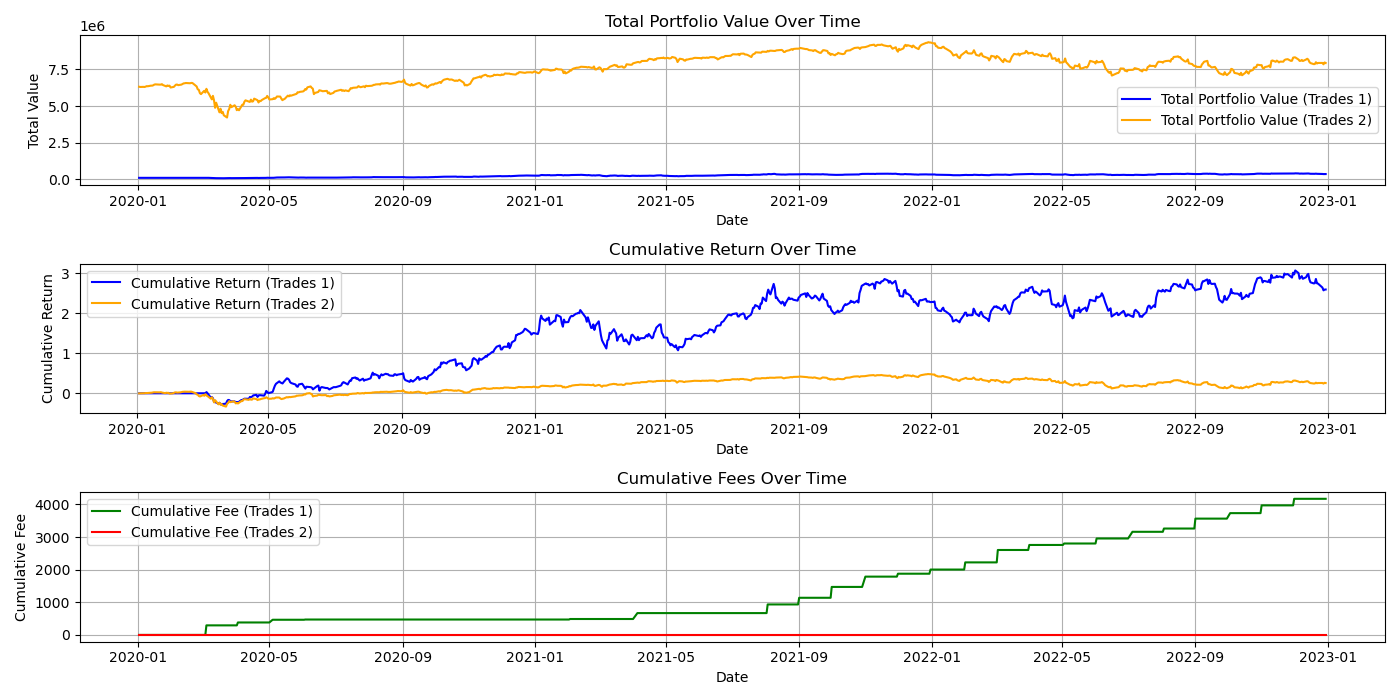


Agent: It seems like you are interested in seeing a more graphical representation or are curious about how the portfolio performs visually over time. Unfortunately, I can't provide real-time graphs here, but I can help you choose another portfolio that might align with your preferences or offer more information about the current or another portfolio's performance trends.

If you're looking for a portfolio with a similar risk score but possibly with different characteristics or asset allocations, I can suggest another option. Alternatively, I can provide more detailed information about the expected performance trends of the current portfolio.

Please let me know your preference or if there's anything specific you're looking for in your investment portfolio!

Your response: more risk

Agent: Thank you for indicating your interest in taking on more risk. Based on your preference, I can suggest a portfolio that has a slightly higher risk profile while still being appropriate for your risk

In [4]:
# Collect responses and generate a summary with the Advisor
responses = chat_interface(chat_model)